### Load Data

In [23]:
## Normalize features? 
## Invert h-bond and charge? 

In [24]:
model_name = 'model_siamese_071222'
num_epochs = 10

In [25]:
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader #To make use of this data loader, all graph attributes in the dataset need to have the same shape. In particular, this data loader should only be used when working with dense adjacency matrices.
from torch_geometric.nn import DenseGCNConv, dense_diff_pool
from torch_geometric.utils import dense_to_sparse
import math

In [26]:
#data_dir_1 = 'C:/Users/david/pyproj/pyg/adl/patch_label_1'
#data_dir_0 = 'C:/Users/david/pyproj/pyg/adl/patch_label_0'
data_dir_1 = 'C:/Users/thoma/OneDrive - ZHAW/ProteinSurfaces-DESKTOP-AQ00763/patch_label_1'
data_dir_0 = 'C:/Users/thoma/OneDrive - ZHAW/ProteinSurfaces-DESKTOP-AQ00763/patch_label_0'

In [27]:
from c_PatchDataset import PatchDataset
dataset = PatchDataset(data_dir_label_0 = data_dir_0,  data_dir_label_1=data_dir_1,  neg_pos_ratio=1)
len(dataset)

572

In [28]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs pairs: {len(dataset)}')

data = dataset[0]  # Get the first graph object.
print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes in each: {data.num_nodes}')
print(f'Number of node features: {data.num_node_features}')


Dataset: PatchDataset(572):
Number of graphs pairs: 572

PairData(adj1=[100, 100], x1=[100, 3], adj2=[100, 100], x2=[100, 3], y=1)
Number of nodes in each: None
Number of node features: 0


c:\Users\thoma\Desktop\ZHAW MLS\David prod\ADLProtProject\.venv\lib\site-packages\torch_geometric\data\storage.py:271: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'adj1', 'y', 'x2', 'adj2', 'x1'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


In [29]:
data.x2

tensor([[-1.3722e-01,  0.0000e+00, -9.9054e-01],
        [-3.0243e-02,  0.0000e+00, -9.9954e-01],
        [ 6.6998e-02,  0.0000e+00,  9.9775e-01],
        [-8.0195e-02,  0.0000e+00,  9.9678e-01],
        [-2.7805e-02,  0.0000e+00,  9.9961e-01],
        [ 5.4906e-02,  0.0000e+00, -9.9849e-01],
        [ 6.7535e-02,  0.0000e+00,  9.9772e-01],
        [-3.7540e-02,  0.0000e+00, -9.9930e-01],
        [-1.4162e-01,  0.0000e+00,  9.8992e-01],
        [ 5.1660e-02,  0.0000e+00, -9.9866e-01],
        [ 1.0746e-01,  0.0000e+00,  9.9421e-01],
        [-3.7490e-02,  1.9489e-02, -9.9911e-01],
        [ 4.1760e-02,  8.4647e-02, -9.9554e-01],
        [-1.2137e-01,  0.0000e+00, -9.9261e-01],
        [-1.4755e-04,  0.0000e+00, -1.0000e+00],
        [ 2.0662e-02,  0.0000e+00,  9.9979e-01],
        [-1.4473e-02,  2.3516e-01, -9.7185e-01],
        [ 1.4049e-01,  0.0000e+00, -9.9008e-01],
        [-1.6496e-01,  0.0000e+00,  9.8630e-01],
        [ 2.8432e-02,  0.0000e+00, -9.9960e-01],
        [-1.4237e-01

In [30]:
# Does not work we do not have pos
#visualize_points(data.pos, data.edge_index)

In [31]:
from torch_geometric.loader import DataLoader 

batch_size = 1

n_train = math.ceil((4/6) * len(dataset))
n_val = math.ceil((len(dataset) - n_train)/2)
n_test = len(dataset) - n_train - n_val

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])
print(f'Number of training graphs pairs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

train_loader = DataLoader(dataset = train_dataset, batch_size= batch_size, shuffle=True)
val_loader = DataLoader(dataset = val_dataset, batch_size= batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size= batch_size, shuffle=True)

Number of training graphs pairs: 382
Number of validation graphs: 95
Number of test graphs: 95


In [32]:
databatch = next(iter(train_loader))
databatch

PairDataBatch(adj1=[100, 100], x1=[100, 3], adj2=[100, 100], x2=[100, 3], y=[1])

### Define Network

In [33]:
class GNN(torch.nn.Module):
    def __init__(self, in_nodes, in_channels, hidden_channels, out_channels,
                 normalize=False, lin=True):
        super(GNN, self).__init__()

        # Each instance of this GNN will have 3 convolutional layers and three batch norm layers        
        self.conv1 = DenseGCNConv(in_channels, hidden_channels, normalize)
        self.bns1 = torch.nn.BatchNorm1d(in_nodes)
        
        self.conv2 = DenseGCNConv(hidden_channels, hidden_channels, normalize)
        self.bns2 = torch.nn.BatchNorm1d(in_nodes)
        
        self.conv3 = DenseGCNConv(hidden_channels, out_channels, normalize)
        self.bns3 = torch.nn.BatchNorm1d(in_nodes)


    def forward(self, x, adj, mask=None):
        
        #Step 1
        x = self.conv1(x, adj, mask)
        x = self.bns1(x)
        
        #Step 2
        x = self.conv2(x, adj, mask)
        x = self.bns2(x)

        #Step 3
        x = self.conv3(x, adj, mask)
        if x.shape[2] != 1: 
            x = self.bns3(x)

        return x


class DiffPool(torch.nn.Module):
    def __init__(self, num_nodes):
        super(DiffPool, self).__init__()

        #Hierarchical Step #1
        in_nodes = num_nodes
        out_nodes = 25 # Number of clusters / nodes in the next layer
        self.gnn1_pool = GNN(in_nodes, dataset.num_features, 16, out_nodes) # PoolGNN --> Cluster Assignment Matrix to reduce to num_nodes
        self.gnn1_embed = GNN(in_nodes, dataset.num_features, 8, 8) # EmbGNN --> Convolutions to create new node embedding

        # Hierarchical Step #2
        in_nodes = out_nodes
        out_nodes = 10
        self.gnn2_pool = GNN(in_nodes, 8, 8, out_nodes)
        self.gnn2_embed = GNN(in_nodes, 8, 12, 16, lin=False)

        # Hierarchical Step #3
        in_nodes = out_nodes
        out_nodes = 1
        self.gnn3_pool = GNN(in_nodes, 16, 16, out_nodes)
        self.gnn3_embed = GNN(in_nodes, 16, 16, 32, lin=False)

        # Final Classifier
        self.lin1 = torch.nn.Linear(32, 64) 
        #self.lin2 = torch.nn.Linear(64, 2)



    def forward(self, x, adj, batch, mask=None):
        
        #if batch == 0: print('Shape of input data batch:')
        #if batch == 0: print(f'Feature Matrix: {tuple(x.shape)}')
        #if batch == 0: print(f'Adjacency Matrix: {tuple(adj.shape)}')
       


        #Hierarchical Step #1
        #if batch == 0: print('Hierarchical Step #1')
        x1 = self.gnn1_embed(x, adj, mask) # node feature embedding
        s = self.gnn1_pool(x, adj, mask) # cluster assignment matrix

        #if batch == 0: print(f'X1 = {tuple(x1.shape)}    S1: {tuple(s.shape)}')

        x, adj, l1, e1 = dense_diff_pool(x1, adj, s, mask) # does the necessary matrix multiplications
        adj = torch.softmax(adj, dim=-1)

        #if batch == 0: print(f'---matmul---> New feature matrix (softmax(s_0.t()) @ z_0) = {tuple(x.shape)}')
        #if batch == 0: print(f'---matmul---> New adjacency matrix (s_0.t() @ adj_0 @ s_0) = {tuple(adj.shape)}')
   


        # Hierarchical Step #2
        #if batch == 0: print('Hierarchical Step #2')
        x2 = self.gnn2_embed(x, adj)
        s = self.gnn2_pool(x, adj)

        #if batch == 0: print(f'X2: {tuple(x2.shape)}    S2: {tuple(s.shape)}')
        
        x, adj, l2, e2 = dense_diff_pool(x2, adj, s)
        adj = torch.softmax(adj, dim=-1)

        #if batch == 0: print(f'---matmul---> New feature matrix (softmax(s_0.t()) @ z_0) = {tuple(x.shape)}')
        #if batch == 0: print(f'---matmul---> New adjacency matrix (s_0.t() @ adj_0 @ s_0) = {tuple(adj.shape)}')
      
        

        # Hierarchical Step #3
        #if batch == 0: print('Hierarchical Step #3')
        x3 = self.gnn3_embed(x, adj)
        s = self.gnn3_pool(x, adj)
        
        #if batch == 0: print(f'X3: {tuple(x3.shape)}    S3: {tuple(s.shape)}')

        x, adj, l3, e3 = dense_diff_pool(x3, adj, s)
        adj = torch.softmax(adj, dim=-1)

        #if batch == 0: print(f'---matmul---> New feature matrix (softmax(s_0.t()) @ z_0) = {tuple(x.shape)}')
        #if batch == 0: print(f'---matmul---> New adjacency matrix (s_0.t() @ adj_0 @ s_0) = {tuple(adj.shape)}')
     
        

        # Final Classification
        #if batch == 0: print('Final Output')
        x = x.mean(dim=1) # Pool the features of all nodes (global mean pool)  dim = 1 refers to columns
        #if batch == 0: print(f'---X Output after mean= {tuple(x.shape)}')

        x = F.relu(self.lin1(x)) # Fully connected layer + relu
        #if batch == 0: print(f'------ X Output 3 after lin= {tuple(x.shape)}')

        
        return x, l1 + l2 + l3, e1 + e2 + e3

In [34]:
# An attempt of a contrastive loss function
#   pairs with label 1 --> should get small euclid dist = small loss
#   pairs with label 0 --> should get large euclid dist = small loss

class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=1.2):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x0, x1, y,epochs):
        # euclidian distance
        #print(x0)
        #print(x1)
        #print(y)
        diff = x0 - x1
        #print(diff)
        pow = torch.pow(diff, 2)
        #print(pow)
        dist_sq = torch.sum(pow, 1)
        #print(dist_sq) # sum of squared distance = 0.5 = 9
        dist = torch.sqrt(dist_sq)
        #print(dist) # euclidean distance = 0.7 = 3

        mdist = self.margin- dist #negative euclidean distance - margin = 0.3 = -2
        #print(mdist)
        dist_marg = torch.clamp(mdist, min=0.0) # only distances <margin will be still positive here = 0.3 = 0
        #print(dist)
        loss =  y * torch.pow(dist, 2) + (1-y) * torch.pow(dist_marg,2)

        # What happens to a pair with squared euclid dist (dist_sq) of 0.5
        # if label = 0 --> 0 + squared clampled euclid distance --> loss = 0.3^2
        # if label = 1 --> squared euclidean distance + 0 --> loss = 0.5

        # What happens to a pair with squared euclid dist (dist_sq) of 9
        # if label = 0 --> 0 + squared clampled euclid distance --> loss = 0
        # if label = 1 --> squared euclidean distance + 0 --> loss = 9

        #print(loss)
        #loss = torch.sum(loss) / 2.0 
        #print(loss)
        return loss

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = DiffPool(num_nodes = 100).to(device)
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 20

def train(epoch):
    batch = 0
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output1, _, _ = model(data.x1, data.adj1, batch)
        output2, _, _ = model(data.x2, data.adj2, batch = None)
        
        #Contrastive Loss
        loss_contrastive = criterion(output1,output2,data.y,epoch)
        loss_contrastive.backward()
        loss_all += data.y.size(0) * loss_contrastive.item()
        optimizer.step()
        batch +=1

    return loss_all / len(train_dataset)


@torch.no_grad()
def test(loader,epochs):
    model.eval()

    distances_lab1 = []
    distances_lab0 = []
    labels = []
    losses = []
    

    for data in loader:
        data = data.to(device)
        output1, _, _ = model(data.x1, data.adj1, batch=None)
        output2, _, _ = model(data.x2, data.adj2, batch=None)

        test_loss_contrastive = criterion(output1, output2, data.y,epochs)
        #diff = output1 -output2
        #print(diff)
        #pow = torch.pow(diff, 2)
        #print(pow)
        #dist_sq = torch.sum(pow, 1)
        #print(dist_sq) # sum of squared distance = 0.5 = 9
        #euclidean_distance = torch.sqrt(dist_sq)
        #print(dist) # euclidean distance = 0.7 = 3
        euclidean_distance = F.pairwise_distance(output1, output2)
        label = data.y

        if int(label) == 1: 
            distances_lab1.append(float(euclidean_distance))
            labels.append(int(label))
            losses.append(float(test_loss_contrastive))
        else:
            distances_lab0.append(float(euclidean_distance))
            labels.append(int(label))
            losses.append(float(test_loss_contrastive))

    return  distances_lab0, distances_lab1, losses, labels



train_distances_lab0 = []
train_distances_lab1 = []
train_losses = []
train_labels = []

validation_distances_lab0 = []
validation_distances_lab1 = []
validation_losses = []
validation_labels = []

test_distances_lab0 = []
test_distances_lab1 = []
test_losses = []
test_labels = []

for epoch in range(1, num_epochs+1):
    
    train_loss = train(epoch)

    train_results = test(train_loader,epoch)
    train_distances_lab0.append(train_results[0])
    train_distances_lab1.append(train_results[1])
    train_losses.append(train_results[2])
    train_labels.append(train_results[3])


    validation_results = test(val_loader,epoch)
    validation_distances_lab0.append(validation_results[0])
    validation_distances_lab1.append(validation_results[1])
    validation_losses.append(validation_results[2])
    validation_labels.append(validation_results[3])

    test_results = test(test_loader,epoch)
    test_distances_lab0.append(test_results[0])
    test_distances_lab1.append(test_results[1])
    test_losses.append(test_results[2])
    test_labels.append(test_results[3])


    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.3f}')
    #Train Acc: {train_acc:.3f}, f'Val Acc: {val_acc:.3f}, Test Acc: {test_acc:.3f}')
    


cpu
Epoch: 001, Train Loss: 197.823
Epoch: 002, Train Loss: 41.866
Epoch: 003, Train Loss: 9.833
Epoch: 004, Train Loss: 3.034
Epoch: 005, Train Loss: 1.249
Epoch: 006, Train Loss: 0.678
Epoch: 007, Train Loss: 0.454
Epoch: 008, Train Loss: 0.347
Epoch: 009, Train Loss: 0.296
Epoch: 010, Train Loss: 0.258
Epoch: 011, Train Loss: 0.236
Epoch: 012, Train Loss: 0.242
Epoch: 013, Train Loss: 0.237
Epoch: 014, Train Loss: 0.229
Epoch: 015, Train Loss: 0.229
Epoch: 016, Train Loss: 0.226
Epoch: 017, Train Loss: 0.226
Epoch: 018, Train Loss: 0.230
Epoch: 019, Train Loss: 0.225
Epoch: 020, Train Loss: 0.234


In [36]:
import numpy as np
import matplotlib.pyplot as plt

def compare_euclid_distances(distances_lab0, distances_lab1):

    w = 0.8    # bar width
    x = [1, 2] # x-coordinates of your bars
    colors = [(0, 0, 1, 1), (1, 0, 0, 1)]    # corresponding colors

    # Epoch 0
    y = [distances_lab0, distances_lab1]


    fig, ax = plt.subplots()
    ax.bar(x,
        height=[np.mean(yi) for yi in y],
        yerr=[np.std(yi) for yi in y],    # error bars
        capsize=12, # error bar cap width in points
        width=w,    # bar width
        tick_label=["Label 0", "Label 1"],
        color=(0,0,0,0),  # face color transparent
        edgecolor=colors,
        )

    for i in range(len(x)):
        # distribute scatter randomly across whole width of bar
        ax.scatter(x[i] + np.random.random(len(y[i])) * w - w / 2, y[i], color=colors[i])

    plt.ylabel = 'Euclidean Distance'
    plt.show()


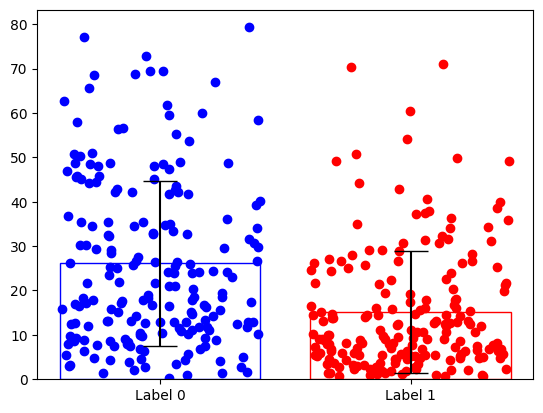

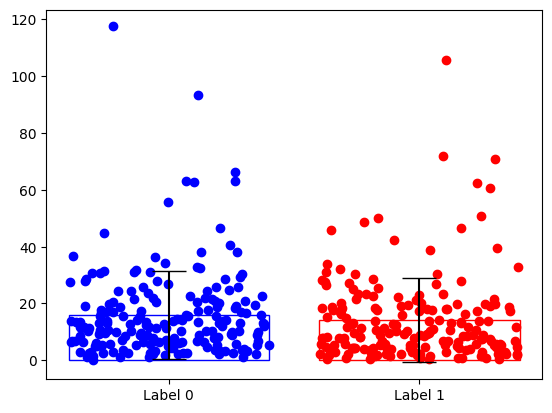

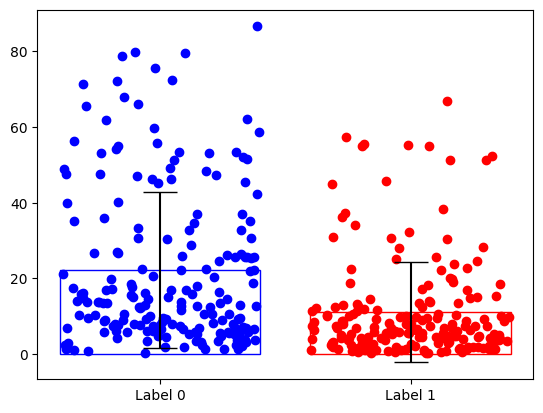

In [51]:
compare_euclid_distances(train_distances_lab0[0], train_distances_lab1[0])
compare_euclid_distances(train_distances_lab0[15], train_distances_lab1[15])

compare_euclid_distances(train_distances_lab0[18], train_distances_lab1[18])

In [38]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
gnn1_pool.conv1.bias 	 torch.Size([16])
gnn1_pool.conv1.lin.weight 	 torch.Size([16, 3])
gnn1_pool.bns1.weight 	 torch.Size([100])
gnn1_pool.bns1.bias 	 torch.Size([100])
gnn1_pool.bns1.running_mean 	 torch.Size([100])
gnn1_pool.bns1.running_var 	 torch.Size([100])
gnn1_pool.bns1.num_batches_tracked 	 torch.Size([])
gnn1_pool.conv2.bias 	 torch.Size([16])
gnn1_pool.conv2.lin.weight 	 torch.Size([16, 16])
gnn1_pool.bns2.weight 	 torch.Size([100])
gnn1_pool.bns2.bias 	 torch.Size([100])
gnn1_pool.bns2.running_mean 	 torch.Size([100])
gnn1_pool.bns2.running_var 	 torch.Size([100])
gnn1_pool.bns2.num_batches_tracked 	 torch.Size([])
gnn1_pool.conv3.bias 	 torch.Size([25])
gnn1_pool.conv3.lin.weight 	 torch.Size([25, 16])
gnn1_pool.bns3.weight 	 torch.Size([100])
gnn1_pool.bns3.bias 	 torch.Size([100])
gnn1_pool.bns3.running_mean 	 torch.Size([100])
gnn1_pool.bns3.running_var 	 torch.Size([100])
gnn1_pool.bns3.num_batches_tracked 	 torch.Size([])
gnn1_embed.conv1.bias 	 

In [39]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {0: {'step': tensor(11460.), 'exp_avg': tensor([ 0.0658,  0.0076,  0.0389, -0.0253,  0.0990,  0.0520,  0.0503, -0.0491,
        -0.0395, -0.0155, -0.0820, -0.0177, -0.0692,  0.0048, -0.0068, -0.0135]), 'exp_avg_sq': tensor([ 22.0002,  45.0519,   6.4269,  26.2561,  17.3186,   3.3813,  12.4738,
         43.8868, 125.1155,  12.9709,   8.3535,  14.4690,  51.9212,  53.7534,
         68.8813,  13.8181])}, 1: {'step': tensor(11460.), 'exp_avg': tensor([[ 1.2526e-02, -2.1164e-03,  1.9209e-02],
        [ 3.9082e-03, -1.6521e-03,  2.7305e-02],
        [ 8.9222e-03, -7.6375e-04, -3.3584e-03],
        [ 1.3559e-02, -1.7452e-03, -3.7313e-02],
        [-9.5011e-04, -2.1945e-03,  2.7755e-02],
        [ 5.5920e-03, -1.5507e-03,  1.8670e-03],
        [ 1.2500e-02, -2.1825e-03, -1.9066e-02],
        [-2.5711e-02,  2.4312e-03,  3.1771e-02],
        [-2.2250e-02,  3.8344e-03,  9.9084e-03],
        [ 4.5129e-03,  2.1123e-04,  1.5128e-02],
        [-1.2023e-02,  1.7924e-03,  

In [40]:
torch.save(model.state_dict(), f'{model_name}_state_dict.pt')

In [41]:
torch.save(model, model_name+'.pt')

In [42]:
train_results

([5.039967060089111,
  2.9724743366241455,
  0.325209379196167,
  3.7244646549224854,
  1.7943934202194214,
  0.27664899826049805,
  4.176661014556885,
  2.7181761264801025,
  0.8257138133049011,
  7.458323955535889,
  5.480461597442627,
  3.049443006515503,
  12.76567554473877,
  4.077723026275635,
  0.2736821472644806,
  1.7346400022506714,
  9.646903991699219,
  24.3457088470459,
  5.952641487121582,
  0.1685463786125183,
  41.964481353759766,
  39.0633544921875,
  8.183717727661133,
  0.6456655859947205,
  2.02899432182312,
  3.640676259994507,
  3.502286195755005,
  1.8068784475326538,
  13.45116138458252,
  0.5916929244995117,
  1.4256943464279175,
  3.334533214569092,
  5.09161376953125,
  5.105195045471191,
  1.1639260053634644,
  9.224519729614258,
  5.765036582946777,
  3.002119302749634,
  4.072312831878662,
  4.419891357421875,
  1.739321231842041,
  2.0448732376098633,
  2.216447353363037,
  0.7246847152709961,
  5.340191841125488,
  2.9733636379241943,
  2.310412406921386

In [43]:
import numpy as np
tr_results = np.asarray(train_results)
tr_results.shape

C:\Users\thoma\AppData\Local\Temp\ipykernel_12996\3520072505.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tr_results = np.asarray(train_results)


(4,)

In [44]:
tr_results[0].shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
import matplotlib.pyplot as plt
np.random.seed(123)

w = 0.8    # bar width
x = [1, 2] # x-coordinates of your bars
colors = [(0, 0, 1, 1), (1, 0, 0, 1)]    # corresponding colors
y = [np.random.random(30) * 2 + 5,       # data series
    np.random.random(10) * 3 + 8]

fig, ax = plt.subplots()
ax.bar(x,
       height=[np.mean(yi) for yi in y],
       yerr=[np.std(yi) for yi in y],    # error bars
       capsize=12, # error bar cap width in points
       width=w,    # bar width
       tick_label=["control", "test"],
       color=(0,0,0,0),  # face color transparent
       edgecolor=colors,
       #ecolor=colors,    # error bar colors; setting this raises an error for whatever reason.
       )

for i in range(len(x)):
    # distribute scatter randomly across whole width of bar
    ax.scatter(x[i] + np.random.random(y[i].size) * w - w / 2, y[i], color=colors[i])

plt.show()

In [ ]:
import numpy as np
np.save(f'{model_name}_training_loss.npy', tr_loss, allow_pickle=True)
np.save(f'{model_name}_training_accuracy.npy', tr_acc, allow_pickle=True)

np.save(f'{model_name}_validation_loss.npy', v_loss, allow_pickle=True)
np.save(f'{model_name}_validation_accuracy.npy', v_acc, allow_pickle=True)

np.save(f'{model_name}_test_loss.npy', tst_loss, allow_pickle=True)
np.save(f'{model_name}_test_accuracy.npy', tst_acc, allow_pickle=True)

In [ ]:
import numpy as np
training_loss = np.load(f'{model_name}_training_loss.npy', allow_pickle=True)
training_accuracy = np.load(f'{model_name}_training_accuracy.npy', allow_pickle=True)

validation_loss = np.load(f'{model_name}_validation_loss.npy', allow_pickle=True)
validation_accuracy = np.load(f'{model_name}_validation_accuracy.npy', allow_pickle=True)

test_loss = np.load(f'{model_name}_test_loss.npy', allow_pickle=True)
test_accuracy = np.load(f'{model_name}_test_accuracy.npy', allow_pickle=True)

In [ ]:
import matplotlib.pyplot as plt

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, num_epochs+1)
 
# Plot and label the training and validation loss values
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(np.arange(0, num_epochs+1, num_epochs/10))
 
# Display the plot
plt.legend(loc='best')
plt.savefig(f'{model_name}_Training and Validation Loss.png')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, num_epochs+1)
 
# Plot and label the training and validation loss values
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.plot(epochs, test_accuracy, label='Test Accuracy')
 
# Add in a title and axes labels
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
 
# Set the tick locations
plt.xticks(np.arange(0, num_epochs+1, num_epochs/10))
plt.ylim(0,1)
 
# Display the plot
plt.legend(loc='best')
plt.savefig(f'{model_name}_Accuracy vs. Epochs.png')
plt.show()

In [ ]:
dataset_fraction = [0,0]

train_fraction = [0,0]
val_fraction = [0,0]
test_fraction = [0,0]

for grph in train_dataset: 
    if grph.y == 1: 
        train_fraction[1] +=1
        dataset_fraction[1] +=1 
    else: 
        train_fraction[0] +=1
        dataset_fraction[0] +=1 

for grph in val_dataset: 
    if grph.y == 1:
         val_fraction[1] +=1
         dataset_fraction[1] +=1  
    else:
         val_fraction[0] +=1
         dataset_fraction[0] +=1

for grph in test_dataset: 
    if grph.y == 1:
         test_fraction[1] +=1
         dataset_fraction[1] +=1 
    else:
         test_fraction[0] +=1
         dataset_fraction[0] +=1

print(f'Overall dataset percentage of label 1 = {dataset_fraction[1]/len(dataset)})')
print(f'Training dataset percentage of label 1 = {train_fraction} = {train_fraction[1]/len(train_dataset)}')
print(f'Validation dataset percentage of label 1 = {val_fraction} = {val_fraction[1]/len(val_dataset)}')
print(f'Test dataset percentage of label 1 = {test_fraction} = {test_fraction[1]/len(test_dataset)}')

### Input Graph: 

In [ ]:
x0, pos0, adj0 = torch.load(f'{model_name}_img0_data.pt')

In [ ]:
# Output of Embedding GNN
print(x0[0].shape)
x0[0]

In [ ]:
print(pos0[0].shape)
pos0[0]

In [ ]:
print(adj0[0].shape)
adj0[0]

In [ ]:
edge_index, _ = dense_to_sparse(adj0[0])
visualize_points(pos0[0].cpu(), edge_index)

### Graph After 1st Reduction

In [ ]:
x1_emb, x1_pool, pos1, adj1, s1= torch.load(f'{model_name}_img1_data.pt')

In [ ]:
# Output of Embedding GNN (adj0 @ x_0 @ w_gnn_emb)
print(x1_emb[0].shape)
x1_emb[0]

In [ ]:
# Output of Pooling GNN: adj_0 @ x_0 @ w_gnn_pool
print(s1[0].shape)
s1[0]

In [ ]:
# Output Coordinate Matrix (pos_out = softmax(s).t() @ pos_in)
print(pos1[0].shape)
pos1[0]

In [ ]:
# Output Feature Matrix (x_out = softmax(s).t() @ x_in)
print(x1_pool[0].shape)
x1_pool[0]

In [ ]:
# Output Adjacency Matrix = softmax(adj_out = softmax(s.t()) @ adj_in @ softmax(s))
print(adj1[0].shape)
adj1[0]

In [ ]:
edge_index, _ = dense_to_sparse(adj1[0])
visualize_points(pos1[0].cpu(), edge_index)

### Graph after 2nd reduction

In [ ]:
x2_emb, x2_pool, pos2, adj2, s2 = torch.load(f'{model_name}_img2_data.pt')

In [ ]:
# Output of Embedding GNN (adj1 @ x1_pool @ w_gnn_emb)
print(x2_emb[0].shape)
x2_emb[0]

In [ ]:
# Output of Pooling GNN: adj1 @ x1_pool @ w_gnn_pool), dim=1
print(s2[0].shape)
s2[0]

In [ ]:
# Output Coordinate Matrix (pos_out = softmax(s.t()) @ pos_in)
print(pos2[0].shape)
pos2[0]

In [ ]:
# Output Feature Matrix (x_out = softmax(s2).t() @ x2_emb)
print(x2_pool[0].shape)
x2_pool[0]

In [ ]:
# Output Adjacency Matrix (adj = softmax(s).T @ adj @ softmax(s)
print(adj2[0].shape)
adj2[0]

In [ ]:
edge_index, _ = dense_to_sparse(adj2[0])
visualize_points(pos2[0].cpu(), edge_index)

### Graph after 3rd reduction

In [ ]:
x3_emb, x3_pool, pos3, adj3, s3 = torch.load(f'{model_name}_img3_data.pt')

In [ ]:
# Output of Embedding GNN (adj_0 @ x_0 @ w_gnn_emb)
print(x3_emb[0].shape)
x3_emb[0]

In [ ]:
# Output of Pooling GNN: torch.softmax(adj_0 @ x_0 @ w_gnn_pool), dim=1)
print(s3[0].shape)
s3[0]

In [ ]:
# Output Coordinate Matrix (pos_out = softmax(s.t()) @ pos_in)
print(pos3[0].shape)
pos3[0]

In [ ]:
# Output Feature Matrix (x_out = softmax(s.t()) @ x_0)
print(x3_pool[0].shape)
x3_pool[0]

In [ ]:
# Output Adjacency Matrix (adj = softmax(s.t()) @ adj @ softmax(s)
print(adj3[0].shape)
adj3[0]

In [ ]:
edge_index, _ = dense_to_sparse(adj3[0])
visualize_points(pos3[0].cpu(), edge_index)